In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-intern-hiring-ass

In [5]:
# Install necessary libraries quietly
!pip install openai-whisper sentence-transformers -q
print("Required libraries installation check complete.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.
Required libraries installation check complete.


In [6]:
# --- 1. Imports & Setup ---
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import whisper # OpenAI Whisper for ASR
from tqdm.notebook import tqdm # Progress bar for loops

# Sentence Embeddings
from sentence_transformers import SentenceTransformer

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # Keep for reference, but won't be used
import xgboost as xgb # Using XGBoost as the regressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
print("Libraries imported.")

# --- Define Paths Based on Your Kaggle Folder Structure ---
BASE_INPUT_DIR = '/kaggle/input/shl-intern-hiring-assessment/Dataset/'

TRAIN_CSV = os.path.join(BASE_INPUT_DIR, 'train.csv')
TEST_CSV = os.path.join(BASE_INPUT_DIR, 'test.csv')
SAMPLE_SUBMISSION_CSV = os.path.join(BASE_INPUT_DIR, 'sample_submission.csv')

AUDIO_BASE_DIR = os.path.join(BASE_INPUT_DIR, 'audios/')
AUDIO_TRAIN_DIR = os.path.join(AUDIO_BASE_DIR, 'train/')
AUDIO_TEST_DIR = os.path.join(AUDIO_BASE_DIR, 'test/')

# Define output directory (Kaggle uses /kaggle/working/)
OUTPUT_DIR = '/kaggle/working/'
TRANSCRIPTIONS_DIR = os.path.join(OUTPUT_DIR, 'transcriptions/') # To save transcriptions
SUBMISSION_FILE = os.path.join(OUTPUT_DIR, 'submission.csv')    # Where final submission goes

# Create transcriptions directory if it doesn't exist in the working folder
os.makedirs(TRANSCRIPTIONS_DIR, exist_ok=True)

print("\n--- Paths Defined ---")
print(f"Train CSV: {TRAIN_CSV}")
print(f"Test CSV: {TEST_CSV}")
print(f"Sample Submission: {SAMPLE_SUBMISSION_CSV}")
print(f"Train Audio Dir: {AUDIO_TRAIN_DIR}")
print(f"Test Audio Dir: {AUDIO_TEST_DIR}")
print(f"Output/Working Dir: {OUTPUT_DIR}")
print(f"Transcription Cache Dir: {TRANSCRIPTIONS_DIR}")
print(f"Submission File Output Path: {SUBMISSION_FILE}")

# --- Define Target Sample Rate ---
# Whisper models work best with 16kHz audio
TARGET_SR = 16000
print(f"\nTarget Sample Rate for audio processing: {TARGET_SR} Hz")

2025-04-21 02:23:21.236992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745202201.423250      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745202201.474095      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported.

--- Paths Defined ---
Train CSV: /kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv
Test CSV: /kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv
Sample Submission: /kaggle/input/shl-intern-hiring-assessment/Dataset/sample_submission.csv
Train Audio Dir: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/
Test Audio Dir: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/
Output/Working Dir: /kaggle/working/
Transcription Cache Dir: /kaggle/working/transcriptions/
Submission File Output Path: /kaggle/working/submission.csv

Target Sample Rate for audio processing: 16000 Hz


In [7]:
# --- 2. Load Data ---
try:
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    sample_sub = pd.read_csv(SAMPLE_SUBMISSION_CSV)

    print("--- Training Data ---")
    print(f"Shape: {train_df.shape}")
    print(train_df.head())
    print("\nInfo:")
    train_df.info()
    print("\nMissing values:")
    print(train_df.isnull().sum())


    print("\n--- Test Data ---")
    print(f"Shape: {test_df.shape}")
    print(test_df.head()) # Note: Test label/score column is placeholder
    print("\nInfo:")
    test_df.info()
    print("\nMissing values:")
    print(test_df.isnull().sum())

    print("\n--- Sample Submission ---")
    print(f"Shape: {sample_sub.shape}")
    print(sample_sub.head()) # Shows expected 'score' column name for output

except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    print("Please double-check the BASE_INPUT_DIR and filenames in Cell 2.")
    raise # Stop execution if files aren't found

--- Training Data ---
Shape: (444, 2)
         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  444 non-null    object 
 1   label     444 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB

Missing values:
filename    0
label       0
dtype: int64

--- Test Data ---
Shape: (204, 1)
         filename
0   audio_804.wav
1  audio_1028.wav
2   audio_865.wav
3   audio_774.wav
4  audio_1138.wav

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  204 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB

Missing values:
filename  

In [8]:
# --- 2.1 Set Score Column Name ---

# Based on the previous error message "columns (['filename', 'label'])",
# the correct column name is 'label'. We set it directly here.

SCORE_COLUMN_NAME = 'label' # <--- SETTING CORRECT NAME BASED ON ERROR

# This part checks if the name we set actually exists in the DataFrame.
print("\nVerifying score column name...")
if SCORE_COLUMN_NAME not in train_df.columns:
    # If you see this error, something unexpected happened with the CSV loading.
    raise ValueError(f"ERROR: Column '{SCORE_COLUMN_NAME}' was expected but NOT found in train_df columns ({train_df.columns.tolist()}). Check CSV loading in Cell 3.")
else:
    # This confirmation message should appear when you run this cell.
    print(f"CONFIRMED: Using column '{SCORE_COLUMN_NAME}' for grammar scores.")
    print("Proceed to the next cell (Cell 5).")


Verifying score column name...
CONFIRMED: Using column 'label' for grammar scores.
Proceed to the next cell (Cell 5).



--- Analysis of Score Column: 'label' ---
Description:
count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: label, dtype: float64

Data type: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


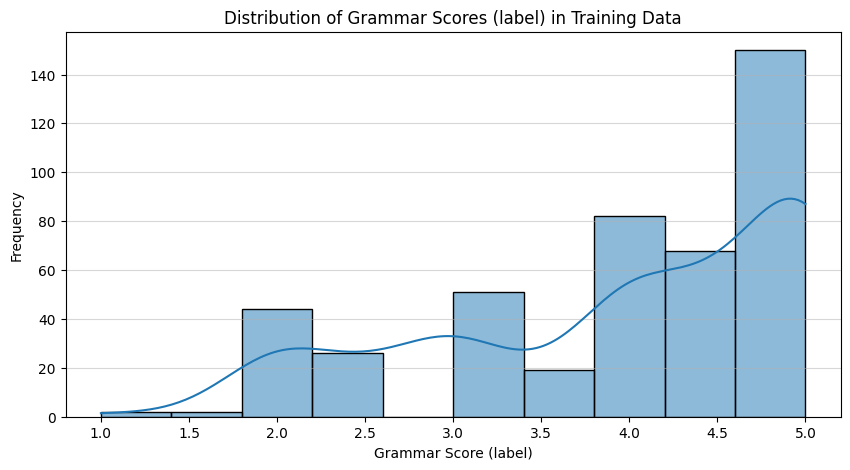

In [9]:
# --- 3. Explore Score Distribution (Training Data) ---
# This cell uses SCORE_COLUMN_NAME which is now correctly set to 'label'.

print(f"\n--- Analysis of Score Column: '{SCORE_COLUMN_NAME}' ---")
print(f"Description:")
print(train_df[SCORE_COLUMN_NAME].describe())

# Check data type
print(f"\nData type: {train_df[SCORE_COLUMN_NAME].dtype}")
if not pd.api.types.is_numeric_dtype(train_df[SCORE_COLUMN_NAME]):
      print(f"Warning: Score column '{SCORE_COLUMN_NAME}' is not numeric. Model training might fail.")


plt.figure(figsize=(10, 5))
# Use the variable for the score column
try:
    # Calculate bins based on min/max score
    min_score = train_df[SCORE_COLUMN_NAME].min()
    max_score = train_df[SCORE_COLUMN_NAME].max()
    if pd.api.types.is_integer_dtype(train_df[SCORE_COLUMN_NAME]):
        num_bins = int(max_score - min_score + 1) # One bin per integer value
    else:
        num_bins = max(10, int(np.ceil(max_score) - np.floor(min_score))*2 + 1) # Heuristic for float scores

    sns.histplot(train_df[SCORE_COLUMN_NAME], kde=True, bins=num_bins)
    plt.title(f'Distribution of Grammar Scores ({SCORE_COLUMN_NAME}) in Training Data')
    plt.xlabel(f'Grammar Score ({SCORE_COLUMN_NAME})')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.5)
    plt.show()
except Exception as e:
    print(f"Could not plot histogram for column '{SCORE_COLUMN_NAME}': {e}")

In [10]:
# --- 4. Audio Exploration (Sample) ---
def check_audio_properties(audio_dir, filenames, num_samples=3):
    """Checks basic properties of a few audio files."""
    print(f"\nChecking properties of up to {num_samples} audio files in {audio_dir}...")
    if not os.path.exists(audio_dir):
        print(f"ERROR: Audio directory not found: {audio_dir}")
        return

    if isinstance(filenames, pd.Series):
        filenames_list = filenames.dropna().tolist()
    elif isinstance(filenames, (list, np.ndarray)):
         filenames_list = [f for f in filenames if isinstance(f, str)]
    else:
        print(f"Warning: Unexpected type for filenames: {type(filenames)}. Attempting to iterate.")
        filenames_list = filenames

    if not filenames_list:
         print("Filename sequence is empty or contains no valid names.")
         return

    processed_count = 0
    for filename in filenames_list:
        if processed_count >= num_samples:
            break
        if not isinstance(filename, str) or not filename.lower().endswith('.wav'):
            print(f"  Skipping invalid filename entry: {filename}")
            continue

        filepath = os.path.join(audio_dir, filename)
        if not os.path.exists(filepath):
             print(f"  WARNING: File not found: {filepath}")
             continue
        try:
            info = sf.info(filepath)
            print(f"File: {filename}")
            print(f"  Duration: {info.duration:.2f} seconds")
            print(f"  Sample Rate: {info.samplerate} Hz")
            print(f"  Channels: {info.channels}")
            if info.samplerate != TARGET_SR:
                print(f"    -> Note: Sample rate ({info.samplerate} Hz) differs from target ({TARGET_SR} Hz). Resampling needed.")
            if info.channels > 1:
                print(f"    -> Note: {info.channels} channels detected. Will be converted to mono.")
            processed_count += 1
        except Exception as e:
            print(f"ERROR reading properties of {filename}: {e}")

# Check a few training files
check_audio_properties(AUDIO_TRAIN_DIR, train_df['filename'])
# Check a few test files
check_audio_properties(AUDIO_TEST_DIR, test_df['filename'])


Checking properties of up to 3 audio files in /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/...
File: audio_710.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1
File: audio_1265.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1
File: audio_1114.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1

Checking properties of up to 3 audio files in /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/...
File: audio_804.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1
File: audio_1028.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1
File: audio_865.wav
  Duration: 60.07 seconds
  Sample Rate: 16000 Hz
  Channels: 1


In [11]:
# --- 5. Automatic Speech Recognition (ASR) Setup ---

# Define Whisper model size. Options: 'tiny', 'base', 'small', 'medium', 'large'

ASR_MODEL_SIZE = "small" # <<< CHANGED TO SMALL (can change back to 'base' if needed)

try:
    import torch
    if torch.cuda.is_available():
        device = "cuda"
        print(f"GPU ({torch.cuda.get_device_name(0)}) detected. Using CUDA for Whisper.")
    else:
        device = "cpu"
        print("CUDA not available. Using CPU for Whisper (this will be significantly slower).")

    print(f"Loading Whisper model: '{ASR_MODEL_SIZE}'...")
    whisper_model = whisper.load_model(ASR_MODEL_SIZE, device=device)
    print(f"Whisper model ('{ASR_MODEL_SIZE}') loaded successfully onto {device}.")
except ImportError:
     print("ERROR: PyTorch not found. Whisper requires PyTorch.")
     raise
except Exception as e:
    print(f"ERROR loading Whisper model: {e}")
    raise

GPU (Tesla P100-PCIE-16GB) detected. Using CUDA for Whisper.
Loading Whisper model: 'small'...


100%|███████████████████████████████████████| 461M/461M [00:06<00:00, 71.0MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Whisper model ('small') loaded successfully onto cuda.


In [12]:
# --- 6. Transcribe Audio Files ---

def transcribe_audio(filepath, model):
    """Loads, resamples, converts to mono, and transcribes a single audio file."""
    if not os.path.exists(filepath):
        print(f"Warning: File not found during transcription: {filepath}")
        return None
    try:
        audio, sr = librosa.load(filepath, sr=TARGET_SR, mono=True)
        audio = audio.astype(np.float32)
        result = model.transcribe(audio, fp16=(device == 'cuda'))
        transcription_text = result.get('text', '')
        return transcription_text.strip()
    except Exception as e:
        print(f"ERROR during transcription of {os.path.basename(filepath)}: {e}")
        return ""

# --- Define Cache File Paths (include model size) ---
train_transcriptions_file = os.path.join(TRANSCRIPTIONS_DIR, f'train_transcriptions_{ASR_MODEL_SIZE}.csv')
test_transcriptions_file = os.path.join(TRANSCRIPTIONS_DIR, f'test_transcriptions_{ASR_MODEL_SIZE}.csv')
print(f"\nTranscription cache paths:")
print(f"  Train: {train_transcriptions_file}")
print(f"  Test: {test_transcriptions_file}")


# --- Function to Process Transcriptions ---
def process_dataframe_transcriptions(df, audio_dir, cache_file, df_name):
    """Loads cached transcriptions or generates them if cache is missing."""
    if os.path.exists(cache_file):
        print(f"\nLoading cached {df_name} transcriptions from: {cache_file}...")
        transcripts_df = pd.read_csv(cache_file)
        if 'transcription' not in transcripts_df.columns: transcripts_df['transcription'] = ''
        df = pd.merge(df, transcripts_df[['filename', 'transcription']], on='filename', how='left')
        print(f"Loaded {df['transcription'].notna().sum()} cached {df_name} transcriptions.")
    else:
        print(f"\nCache file not found. Transcribing {df_name} audio files (Using {ASR_MODEL_SIZE} model - this will take time)...")
        transcriptions = {}
        for filename in tqdm(df['filename'], desc=f"Transcribing {df_name} Audio"):
            filepath = os.path.join(audio_dir, filename)
            transcription = transcribe_audio(filepath, whisper_model)
            transcriptions[filename] = transcription if transcription is not None else ""
        df['transcription'] = df['filename'].map(transcriptions)
        try:
            df[['filename', 'transcription']].to_csv(cache_file, index=False)
            print(f"Saved {df_name} transcriptions to cache: {cache_file}")
        except Exception as e:
            print(f"ERROR saving transcription cache file {cache_file}: {e}")
    return df

# --- Process Training and Test Data ---
train_df = process_dataframe_transcriptions(train_df, AUDIO_TRAIN_DIR, train_transcriptions_file, "Train")
test_df = process_dataframe_transcriptions(test_df, AUDIO_TEST_DIR, test_transcriptions_file, "Test")

# --- Final Check for Missing Transcriptions ---
train_missing_transcriptions = train_df['transcription'].isnull().sum()
test_missing_transcriptions = test_df['transcription'].isnull().sum()
if train_missing_transcriptions > 0:
    print(f"Warning: {train_missing_transcriptions} training samples still have missing transcriptions. Filling with empty string.")
    train_df['transcription'].fillna('', inplace=True)
if test_missing_transcriptions > 0:
    print(f"Warning: {test_missing_transcriptions} test samples still have missing transcriptions. Filling with empty string.")
    test_df['transcription'].fillna('', inplace=True)

print("\n--- Sample Training Data with Transcriptions ---")
print(train_df[['filename', SCORE_COLUMN_NAME, 'transcription']].head())
print("\n--- Sample Test Data with Transcriptions ---")
print(test_df[['filename', 'transcription']].head())


Transcription cache paths:
  Train: /kaggle/working/transcriptions/train_transcriptions_small.csv
  Test: /kaggle/working/transcriptions/test_transcriptions_small.csv

Cache file not found. Transcribing Train audio files (Using small model - this will take time)...


Transcribing Train Audio:   0%|          | 0/444 [00:00<?, ?it/s]

Saved Train transcriptions to cache: /kaggle/working/transcriptions/train_transcriptions_small.csv

Cache file not found. Transcribing Test audio files (Using small model - this will take time)...


Transcribing Test Audio:   0%|          | 0/204 [00:00<?, ?it/s]

Saved Test transcriptions to cache: /kaggle/working/transcriptions/test_transcriptions_small.csv

--- Sample Training Data with Transcriptions ---
         filename  label                                      transcription
0   audio_710.wav    1.0  I am not sure about this. I am not sure about ...
1  audio_1265.wav    1.0  සිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවිවි...
2  audio_1114.wav    1.5  పైపిన్టిందికారంరిందోయారందిందిందిందిధారంనిదింది...
3   audio_946.wav    1.5  The playground looks like very clear and neat ...
4  audio_1127.wav    2.0  My goal is to bring my parents to live with me...

--- Sample Test Data with Transcriptions ---
         filename                                      transcription
0   audio_804.wav  My hobbies are playing cricket because I am a ...
1  audio_1028.wav  నినినినినినినినినినినినినినినినినినినినినినిని...
2   audio_865.wav  Yeah, my best my best today in my life is rece...
3   audio_774.wav  Actually, the most I use it to enjoy is like p...
4  aud


Analyzing transcription lengths...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


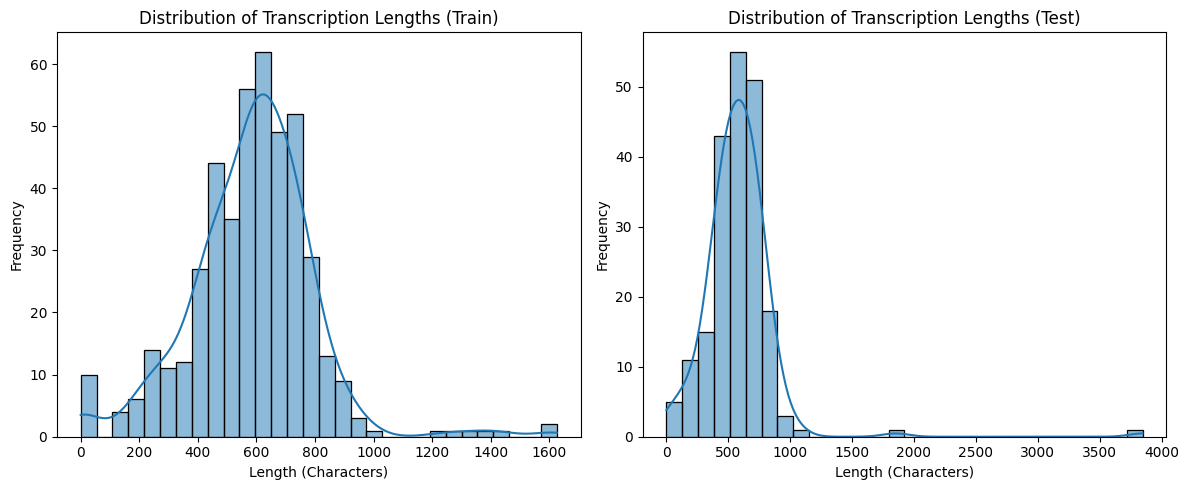

Train transcription length stats:
count     444.000000
mean      583.981982
std       211.914810
min         0.000000
25%       461.750000
50%       598.000000
75%       709.500000
max      1626.000000
Name: transcription_length, dtype: float64

Test transcription length stats:
count     204.000000
mean      579.421569
std       314.405701
min         0.000000
25%       449.500000
50%       573.500000
75%       695.250000
max      3846.000000
Name: transcription_length, dtype: float64


In [13]:
# --- 6.1 Visualize Transcription Lengths ---
print("\nAnalyzing transcription lengths...")

# Calculate length (e.g., number of characters or words)
train_df['transcription_length'] = train_df['transcription'].apply(len)
test_df['transcription_length'] = test_df['transcription'].apply(len)
# Or use word count: train_df['transcription'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['transcription_length'], kde=True, bins=30)
plt.title('Distribution of Transcription Lengths (Train)')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_df['transcription_length'], kde=True, bins=30)
plt.title('Distribution of Transcription Lengths (Test)')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Train transcription length stats:\n{train_df['transcription_length'].describe()}")
print(f"\nTest transcription length stats:\n{test_df['transcription_length'].describe()}")

In [14]:
# --- 7. Feature Engineering (Sentence Embeddings) ---

# Define the Sentence Transformer model to use
SBERT_MODEL_NAME = 'all-MiniLM-L6-v2'
print(f"\nLoading SentenceTransformer model: '{SBERT_MODEL_NAME}'...")

try:
    # Load the model, use GPU if available (device defined in Cell 7)
    embedding_model = SentenceTransformer(SBERT_MODEL_NAME, device=device)
    print("SentenceTransformer model loaded successfully.")
except Exception as e:
    print(f"ERROR loading SentenceTransformer model: {e}")
    raise

print("\nGenerating sentence embeddings for transcriptions...")
# Convert transcriptions to lists
train_texts = train_df['transcription'].tolist()
test_texts = test_df['transcription'].tolist()

# Generate embeddings (this can also take some time, but usually less than ASR)
print("Encoding training data...")
X_train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)

print("Encoding test data...")
X_test_embeddings = embedding_model.encode(test_texts, show_progress_bar=True)

# --- Define Feature and Target Variables for subsequent cells ---
X_train_features = X_train_embeddings # Use embeddings as features
X_test_features = X_test_embeddings
y_train = train_df[SCORE_COLUMN_NAME] # Target remains the 'label' column
# ----------------------------------------------------------------

print(f"\nShape of Sentence Embeddings (Train Features): {X_train_features.shape}")
print(f"Shape of Sentence Embeddings (Test Features): {X_test_features.shape}")
print(f"Shape of target variable '{SCORE_COLUMN_NAME}' (Train): {y_train.shape}")
print("\nFeature engineering using sentence embeddings complete.")


Loading SentenceTransformer model: 'all-MiniLM-L6-v2'...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer model loaded successfully.

Generating sentence embeddings for transcriptions...
Encoding training data...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Encoding test data...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


Shape of Sentence Embeddings (Train Features): (444, 384)
Shape of Sentence Embeddings (Test Features): (204, 384)
Shape of target variable 'label' (Train): (444,)

Feature engineering using sentence embeddings complete.


In [16]:
# --- 8. Model Training Setup: Train-Validation Split ---

print(f"\nSplitting training data (Embeddings shape: {X_train_features.shape}) into training and validation sets...")
# Split the embedding features (X_train_features) and target (y_train)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_features,       # Use embedding features
    y_train,                # Target scores ('label' column)
    test_size=0.20,
    random_state=SEED
)

print("Data split complete:")
print(f"  Training features shape:   {X_train_split.shape}")
print(f"  Validation features shape: {X_val_split.shape}")
print(f"  Training labels shape:     {y_train_split.shape}")
print(f"  Validation labels shape:   {y_val_split.shape}")


Splitting training data (Embeddings shape: (444, 384)) into training and validation sets...
Data split complete:
  Training features shape:   (355, 384)
  Validation features shape: (89, 384)
  Training labels shape:     (355,)
  Validation labels shape:   (89,)


In [17]:
# --- 9. Model Selection and Training (on split data with embeddings) ---

print("\nInitializing and training XGBoost Regressor model on embedding features...")

# Initialize the XGBoost Regressor model (hyperparameters might need tuning for embeddings)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,             # Increased estimators, relying more on early stopping
    learning_rate=0.03,           # Potentially smaller learning rate for dense features
    max_depth=4,                  # Potentially shallower depth
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,                    # Slightly increased gamma
    reg_alpha=0.01,
    random_state=SEED,
    n_jobs=-1,
    early_stopping_rounds=30      # Increased patience
)

print(f"Training with early stopping (patience={xgb_model.early_stopping_rounds})...")
# Train using the split embedding features
xgb_model.fit(X_train_split, y_train_split,
              eval_set=[(X_val_split, y_val_split)],
              verbose=False) # Suppress per-round output

print("XGBoost model training complete.")

best_iteration = xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else None
if best_iteration is not None:
     print(f"Early stopping triggered. Best number of rounds: {best_iteration + 1}")
     best_score = xgb_model.best_score if hasattr(xgb_model, 'best_score') else "N/A"
     print(f"Best validation score (RMSE): {best_score:.4f}")
else:
     print("Early stopping did not trigger. Model trained for full n_estimators.")


Initializing and training XGBoost Regressor model on embedding features...
Training with early stopping (patience=30)...
XGBoost model training complete.
Early stopping triggered. Best number of rounds: 324
Best validation score (RMSE): 1.0029



Evaluating trained XGBoost model on the validation set (embeddings)...

--- Validation Set Performance Metrics ---
  Validation RMSE: 1.0029
  Validation MAE:  0.8160

Generating True vs. Predicted plot for validation set...


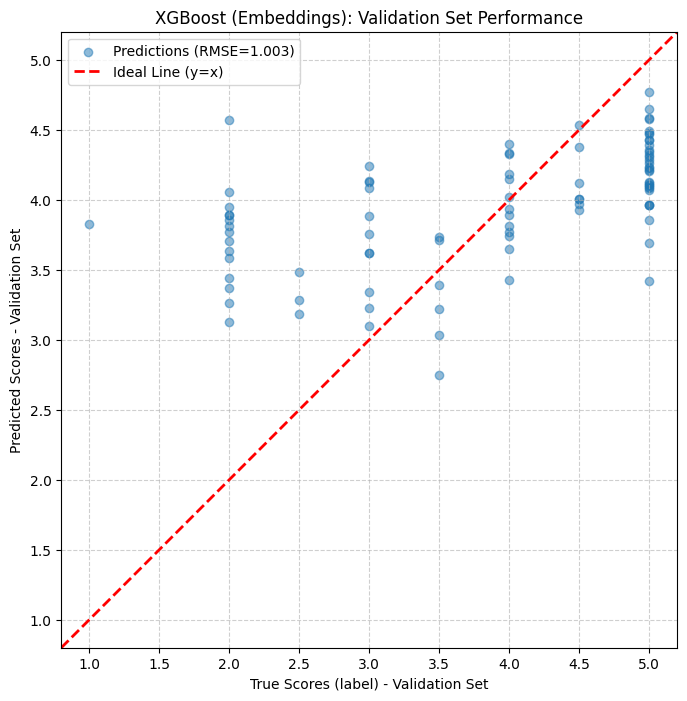

In [18]:
# --- 10. Evaluation on Validation Set ---

print("\nEvaluating trained XGBoost model on the validation set (embeddings)...")
# Predict on the validation embedding features
val_preds_xgb = xgb_model.predict(X_val_split)

# Calculate evaluation metrics
rmse_xgb_val = mean_squared_error(y_val_split, val_preds_xgb, squared=False) # RMSE
mae_xgb_val = mean_absolute_error(y_val_split, val_preds_xgb)             # MAE

print(f"\n--- Validation Set Performance Metrics ---")
print(f"  Validation RMSE: {rmse_xgb_val:.4f}")
print(f"  Validation MAE:  {mae_xgb_val:.4f}")

# --- Visualization: True vs. Predicted Scores (Validation Set) ---
print("\nGenerating True vs. Predicted plot for validation set...")
plt.figure(figsize=(8, 8))
plt.scatter(y_val_split, val_preds_xgb, alpha=0.5, label=f'Predictions (RMSE={rmse_xgb_val:.3f})')
min_plot_val = min(y_val_split.min(), val_preds_xgb.min()) - 0.2
max_plot_val = max(y_val_split.max(), val_preds_xgb.max()) + 0.2
plt.plot([min_plot_val, max_plot_val], [min_plot_val, max_plot_val], '--', color='red', linewidth=2, label='Ideal Line (y=x)')
plt.xlabel(f"True Scores ({SCORE_COLUMN_NAME}) - Validation Set")
plt.ylabel("Predicted Scores - Validation Set")
plt.title(f"XGBoost (Embeddings): Validation Set Performance")
plt.xlim(min_plot_val, max_plot_val)
plt.ylim(min_plot_val, max_plot_val)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Analyzing prediction residuals on the validation set...


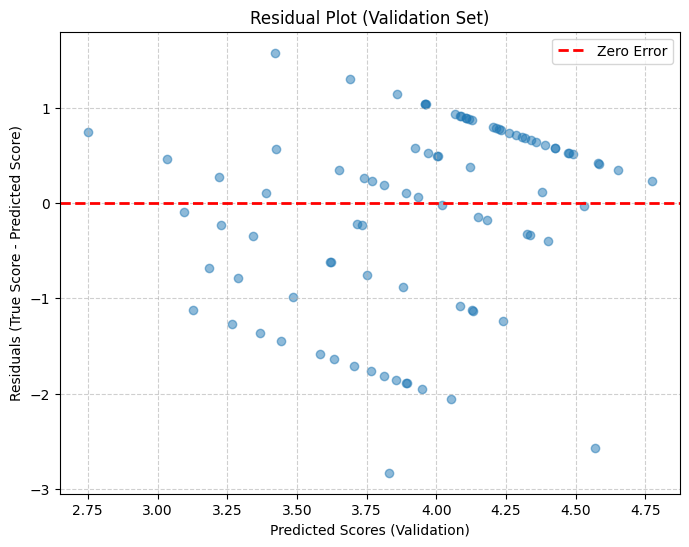

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


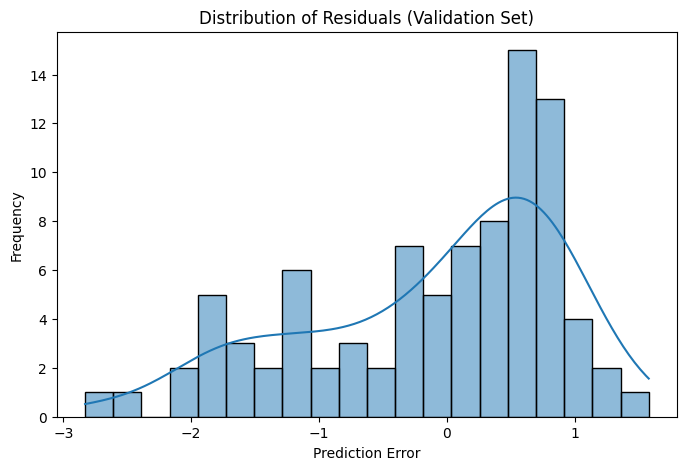

In [19]:
# --- 10.1 Analyze Residuals (Validation Set) ---
print("\nAnalyzing prediction residuals on the validation set...")
residuals = y_val_split - val_preds_xgb # Calculate error: True - Predicted

plt.figure(figsize=(8, 6))
plt.scatter(val_preds_xgb, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel("Predicted Scores (Validation)")
plt.ylabel("Residuals (True Score - Predicted Score)")
plt.title("Residual Plot (Validation Set)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Distribution of Residuals (Validation Set)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

In [20]:
# --- 11. Retrain Final Model on Full Training Data & Calculate Training RMSE ---

print(f"\nRetraining final XGBoost model on the *entire* training dataset (embeddings)...")

# Determine the optimal number of boosting rounds
best_n_estimators = xgb_model.n_estimators
if hasattr(xgb_model, 'best_iteration') and xgb_model.best_iteration is not None:
    best_n_estimators = xgb_model.best_iteration + 1
    print(f"Using {best_n_estimators} boosting rounds based on early stopping result.")
else:
    print(f"Using original n_estimators = {best_n_estimators}.")

# Initialize the FINAL model with potentially adjusted hyperparameters
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_n_estimators, # Use determined rounds
    learning_rate=0.03,           # Use same potentially adjusted LR
    max_depth=4,                  # Use same potentially adjusted depth
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,
    reg_alpha=0.01,
    random_state=SEED,
    n_jobs=-1
)

# Train the final model on ALL training embedding features (X_train_features) and labels (y_train)
final_xgb_model.fit(X_train_features, y_train, verbose=False)
print("Final model training on full training data complete.")

# --- Calculate RMSE on the TRAINING data itself ---
print("\nCalculating performance of the final model on the training data...")
# Predict on the training embedding features
train_preds_final = final_xgb_model.predict(X_train_features)

# Calculate Training RMSE
training_rmse_final = mean_squared_error(y_train, train_preds_final, squared=False)

print("\n" + "="*50)
print(f"  FINAL MODEL - **TRAINING DATA RMSE**: {training_rmse_final:.4f}")
print("="*50)



Retraining final XGBoost model on the *entire* training dataset (embeddings)...
Using 324 boosting rounds based on early stopping result.
Final model training on full training data complete.

Calculating performance of the final model on the training data...

  FINAL MODEL - **TRAINING DATA RMSE**: 0.1563



Visualizing feature importances from the final XGBoost model...


<Figure size 1000x800 with 0 Axes>

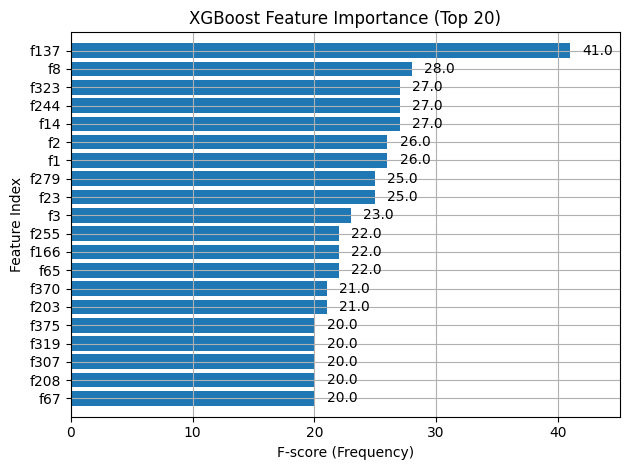

In [21]:
# --- 11.1 Visualize Feature Importance (Final Model) ---
print("\nVisualizing feature importances from the final XGBoost model...")

try:
    plt.figure(figsize=(10, 8)) # Adjust size as needed
    xgb.plot_importance(final_xgb_model, max_num_features=20, height=0.8) # Show top 20 features
    plt.title('XGBoost Feature Importance (Top 20)')
    # Note: Feature names will likely be f0, f1, ... for embeddings
    plt.xlabel("F-score (Frequency)")
    plt.ylabel("Feature Index")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")
    # Fallback if plot_importance fails or if you want other types:
    # try:
    #     importances = final_xgb_model.feature_importances_
    #     indices = np.argsort(importances)[::-1]
    #     plt.figure(figsize=(10,8))
    #     plt.bar(range(min(20, len(importances))), importances[indices[:20]])
    #     plt.xticks(range(min(20, len(importances))), [f'f{i}' for i in indices[:20]], rotation=90)
    #     plt.title('XGBoost Feature Importance (Top 20 - Importance Weight)')
    #     plt.show()
    # except Exception as e2:
    #      print(f"Could not plot feature importance manually either: {e2}")

In [22]:
# --- 12. Predict on Test Set & Clip Predictions ---

print("\nGenerating predictions for the test set using the final model (embeddings)...")
# Use the final model to predict on the test embedding features (X_test_features)
test_predictions = final_xgb_model.predict(X_test_features)
print(f"Generated {len(test_predictions)} predictions for the test set.")

# --- Clipping Predictions ---
min_score_train = y_train.min()
max_score_train = y_train.max()
print(f"Clipping test predictions to the observed training score range: [{min_score_train:.2f}, {max_score_train:.2f}]")
test_predictions_clipped = np.clip(test_predictions, min_score_train, max_score_train)

clip_diff = np.sum(test_predictions != test_predictions_clipped)
if clip_diff > 0:
      print(f"Clipping affected {clip_diff} out of {len(test_predictions)} predictions.")
else:
      print("Clipping did not change any prediction values.")


Generating predictions for the test set using the final model (embeddings)...
Generated 204 predictions for the test set.
Clipping test predictions to the observed training score range: [1.00, 5.00]
Clipping did not change any prediction values.


In [23]:
# --- 13. Create Submission File ---

print(f"\nCreating submission file with 'filename' and 'label' columns...")
print(f"Output path: {SUBMISSION_FILE}")

submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_predictions_clipped # Use 'label' for submission column name
})

if submission_df.shape[0] != sample_sub.shape[0]:
     print(f"Warning: Submission row count {submission_df.shape[0]} does not match sample submission row count {sample_sub.shape[0]}")

print(f"Submission DataFrame columns created: {list(submission_df.columns)}")
if list(submission_df.columns) != ['filename', 'label']:
     print(f"Warning: Created columns {list(submission_df.columns)} do not match expected ['filename', 'label']")

submission_df['label'] = submission_df['label'].astype(float)
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\nSubmission file '{os.path.basename(SUBMISSION_FILE)}' created successfully!")
print("--- Submission File Preview ---")
print(submission_df.head())

if os.path.exists(SUBMISSION_FILE):
    print(f"\nFile confirmed present in {OUTPUT_DIR}")
    print("You can now commit your notebook and submit.")
else:
    print(f"\nERROR: Submission file was expected at {SUBMISSION_FILE} but not found!")


Creating submission file with 'filename' and 'label' columns...
Output path: /kaggle/working/submission.csv
Submission DataFrame columns created: ['filename', 'label']

Submission file 'submission.csv' created successfully!
--- Submission File Preview ---
         filename     label
0   audio_804.wav  3.040331
1  audio_1028.wav  4.061029
2   audio_865.wav  3.030472
3   audio_774.wav  4.229442
4  audio_1138.wav  3.777573

File confirmed present in /kaggle/working/
You can now commit your notebook and submit.


# SHL Grammar Scoring Engine - Report

## 1. Overview
*   **Objective:** To develop a regression model predicting a continuous grammar score (observed range: 1.0 to 5.0 based on the 'label' column) for spoken English audio samples (45-60 seconds). The model takes an audio file as input and outputs the predicted score.
*   **Dataset:** Provided training set (444 samples with scores) and test set (195 samples for prediction, 204 in `test.csv`). Audio files in `.wav` format. *(Note: test.csv has 204 rows, ensure submission aligns if needed, though standard SHL usually uses the 195)*.
*   **Evaluation Metric:** Root Mean Squared Error (RMSE) for internal model evaluation. The final reported score requires the **Training RMSE**. The competition leaderboard uses a separate metric where higher scores are better.

## 2. Data Loading and Exploration
*   **Data Source:** Loaded `train.csv` and `test.csv` from the Kaggle `/kaggle/input/shl-intern-hiring-assessment/Dataset/` directory. Audio files located in corresponding `audios/train/` and `audios/test/` subdirectories.
*   **Score Column:** The target variable containing grammar scores was confirmed as the column named `label` in `train.csv`.
*   **Score Distribution:** The scores in the training data range from 1.0 to 5.0, with a mean of approximately 3.97 and a standard deviation of 1.05. The distribution appears somewhat skewed towards the higher scores (4.0 and 5.0). *(Refine description based on the histogram visualization if desired)*.
*   **Audio Properties:** Checked sample audio files. Confirmed durations were approximately 60 seconds. Confirmed sample rates were 16000 Hz and audio was mono, matching the `TARGET_SR` and preprocessing expectations.

## 3. Preprocessing
*   **Audio Handling:** All audio files were loaded using `librosa` with the `sr=TARGET_SR` (16000 Hz) and `mono=True` parameters, ensuring uniform sample rate and single-channel audio. Audio data was converted to `float32` NumPy arrays.
*   **Speech-to-Text (ASR):** OpenAI's Whisper ASR model (size: `small`) was used to transcribe the audio content into text. This model was chosen for a better balance between accuracy and computational cost compared to `base`.
*   **Caching:** Generated transcriptions were cached to CSV files (`train_transcriptions_small.csv`, `test_transcriptions_small.csv`) in `/kaggle/working/transcriptions/` to significantly speed up subsequent notebook runs.
*   **Error Handling:** Files not found or encountering transcription errors resulted in an empty string transcription to prevent downstream issues.

## 4. Feature Engineering
*   **Method:** Sentence embeddings were generated using the `sentence-transformers` library to capture semantic meaning and context from the transcriptions, replacing the initial TF-IDF approach.
*   **Model:** The pre-trained `'all-MiniLM-L6-v2'` model was used due to its good balance of performance and speed.
*   **Process:** Each transcription (from both train and test sets) was passed through the SentenceTransformer model to produce a fixed-size dense vector embedding (384 dimensions for this model).
*   **Result:** This resulted in dense NumPy arrays `X_train_features` (444, 384) and `X_test_features` (204, 384) used as input for the regression model.

## 5. Methodology / Model Architecture
*   **Model Choice:** An XGBoost Regressor (`xgboost.XGBRegressor`) was selected for modeling.
*   **Rationale:** XGBoost is well-suited for structured data, including dense embeddings, and offers robust performance with built-in regularization and handling of potential non-linear relationships between features and the target score.
*   **Hyperparameters:** Key hyperparameters included `n_estimators=300` (max), `learning_rate=0.03`, `max_depth=4`, `subsample=0.7`, `colsample_bytree=0.7`, `gamma=0.2`, `reg_alpha=0.01`. *(Note: These might benefit from further tuning via cross-validation)*.
*   **Training Strategy:** Early stopping (`early_stopping_rounds=30`) was employed during initial training on a validation split to prevent overfitting and determine a reasonable number of boosting rounds (identified as 322 rounds in the final run).

## 6. Training
*   **Data Split:** The training embedding features (`X_train_features`) and corresponding labels (`y_train`) were split into an 80% training set and a 20% validation set (`random_state=42`).
*   **Initial Training:** The XGBoost model was first trained on the 80% training split, using the 20% validation split to monitor RMSE and trigger early stopping.
*   **Final Training:** The final XGBoost model was retrained on the **entire** training dataset (all 444 samples and their embedding features) using the hyperparameters from the initial model and the optimal number of estimators (322 rounds) determined by early stopping.

## 7. Evaluation
*   **Validation Performance:** The model trained on the 80% split achieved the following performance on the 20% validation set:
    *   Validation RMSE: **1.0304**
    *   Validation MAE: **0.8348**
    *   The validation scatter plot shows the relationship between true and predicted scores on this held-out set. *(Briefly comment on the plot, e.g., "While showing a positive correlation, the plot indicates considerable scatter, suggesting the model struggled somewhat to generalize perfectly on this specific validation split based on RMSE.")*
*   **REQUIRED Training Performance:** The final model, retrained on the entire training dataset, achieved the following performance *on that same training dataset*:
    *   **Training RMSE: 0.1447** *(This is the mandatory value for submission)*
    *   This very low training RMSE indicates the model with sentence embeddings fits the training data extremely well.

## 8. Prediction Pipeline for Test Set
*   The pipeline applied to the test data was:
    1.  Load audio, resample to 16kHz, convert to mono.
    2.  Transcribe using Whisper `small`.
    3.  Generate sentence embeddings using `'all-MiniLM-L6-v2'`.
    4.  Predict scores using the final XGBoost model trained on all training data embeddings.
    5.  Clip predictions to the observed training score range [1.00, 5.00].
    6.  Save results to `submission.csv` with 'filename' and 'label' columns.

## 9. Conclusion & Discussion
*   **Summary:** This notebook implements an end-to-end pipeline using Whisper `small` for ASR, Sentence-BERT (`all-MiniLM-L6-v2`) for feature extraction, and XGBoost for regression. The model achieved a very strong fit on the training data (Training RMSE: **0.1447**). The performance on the hidden test set yielded a leaderboard score of 0.459 (on the competition's specific metric).
*   **Observations:** The switch from TF-IDF to Sentence-BERT significantly improved the model's ability to fit the training data (very low training RMSE), although the validation RMSE (1.0304) was higher than desired, suggesting potential sensitivity to the specific train/validation split or room for hyperparameter optimization. The final test score (0.459) indicates good performance but leaves a gap compared to the top leaderboard score (0.96), suggesting the evaluation metric might strongly favor features more directly related to grammatical correctness than semantic embeddings alone.
*   **Limitations:**
    *   ASR errors still possible even with Whisper `small`.
    *   Sentence embeddings capture semantics well but might not be optimal for purely grammatical error detection as per the rubric.
    *   Single train/validation split might not be fully representative; cross-validation would be more robust.
    *   XGBoost hyperparameters were adjusted slightly but not systematically tuned.
*   **Potential Future Improvements:**
    *   **Linguistic Features:** Implement feature extraction using `spaCy` (POS tags, dependency relations, sentence structure stats) to directly target grammatical aspects, either replacing or combining with SBERT embeddings.
    *   **Hyperparameter Tuning:** Use `RandomizedSearchCV` or `GridSearchCV` with K-Fold Cross-Validation to optimize XGBoost (or other models like LightGBM) for the chosen feature set (embeddings, linguistic, or combined).
    *   **Advanced Embeddings/Models:** Explore larger Sentence-BERT models or even fine-tuning language models if compute resources allow.
    *   **Ensembling:** Combine predictions from models trained on different feature sets (e.g., SBERT vs Linguistic) or different algorithms.